In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from example_lorenz import get_lorenz_data
from sindy_utils import library_size
import random
from training import train_network
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

BASE_SEED = 123

Instructions for updating:
non-resource variables are not supported in the long term


# Generate data

In [2]:
# generate training, validation, testing data
noise_strength = 1e-6
training_data = get_lorenz_data(1024, noise_strength=noise_strength)
validation_data = get_lorenz_data(20, noise_strength=noise_strength)

In [3]:
training_data['z'].shape

(1024, 250, 3)

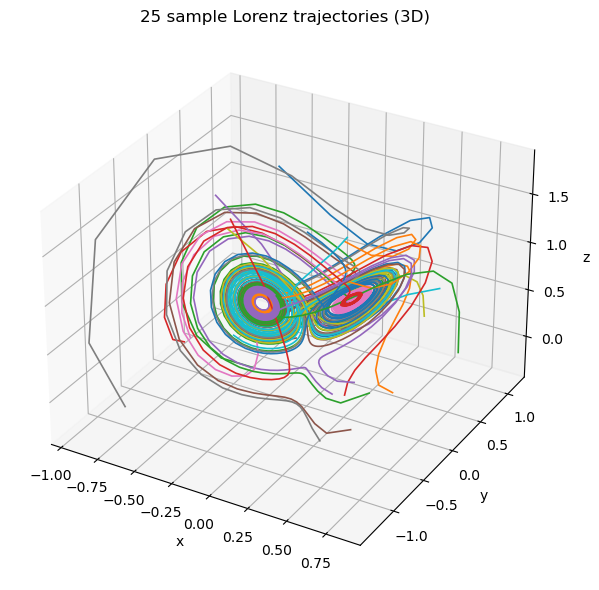

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Z = training_data['z']
n_traj = 25
idx = np.random.choice(Z.shape[0], n_traj, replace=False)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i in idx:
    traj = Z[i]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=1.2)

ax.set_title(f"{n_traj} sample Lorenz trajectories (3D)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()


# Set up model and training parameters

In [5]:
params = {}

params['input_dim'] = 128
params['latent_dim'] = 3
params['model_order'] = 1
params['poly_order'] = 3
params['include_sine'] = False
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], params['include_sine'], True)

# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_z'] = 0.0 # WHAT???
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_regularization'] = 1e-5

params['activation'] = 'sigmoid'
params['widths'] = [64,32]

# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = 1024
params['learning_rate'] = 1e-3

params['data_path'] = os.getcwd() + '/'
params['print_progress'] = True
params['print_frequency'] = 100

# training time cutoffs
params['max_epochs'] = 5001
params['refinement_epochs'] = 1001

# Run training experiments

In [6]:
import warnings
warnings.filterwarnings("ignore")


In [7]:
num_experiments = 5
df = pd.DataFrame()
warnings.filterwarnings("ignore")
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)

    # ---- set seeds for this experiment ----
    seed = BASE_SEED + i
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)  #tf.compat.v1.set_random_seed(seed)
    # ---------------------------------------

    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

    params['save_name'] = 'lorenz_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

    tf.reset_default_graph()

    results_dict = train_network(training_data, validation_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)

df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')

EXPERIMENT 0




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



TRAINING


Epoch 0
   training loss 0.06161250174045563, (0.058528334, 2055.742, 30.760897, 0.8075956)
   validation loss 0.05023350566625595, (0.048187636, 1720.4176, 20.377932, 0.8075956)
decoder loss ratio: 0.239008, decoder SINDy loss  ratio: 1.229162
Epoch 100
   training loss 7.024023943813518e-05, (2.5454228e-05, 1.4173707, 0.2685634, 1.7929673)
   validation loss 6.041375672793947e-05, (1.5561358e-05, 0.8102981, 0.26922727, 1.7929673)
decoder loss ratio: 0.000077, decoder SINDy loss  ratio: 0.016239
Epoch 20

KeyboardInterrupt: 

In [8]:
df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')